## Ch `05`: Concept `03`

# Self-organizing map

## Practical explanation

### Main data 
Let's say we have some inputs of some size, to keep it close to the example used this data has size 3
\begin{equation*}
\mathbf{X} =  \begin{bmatrix}
x_{1} & x_{2} & x_{3}
\end{bmatrix}
\end{equation*}

We want to cluster such inputs of size 3 in to a 2D grid, to keep to the notation of the example the grid size will be 4 x 4

Each node of this grid has the same dimensions as the input. In the example the nodes are represented in a 16 x 3 matrix. So it's the 4x4 node grid flatten with the dimensions of each node expanded (e.g. $n_{1,1}, n_{1,2}, n_{1,3}$)

\begin{equation*}
\mathbf{Nodes} =   \begin{pmatrix}
  n_{1,1} & n_{1,2} & n_{1,3} \\
  n_{2,1} & n_{2,2} & n_{2,3} \\
  \vdots  & \vdots  & \vdots  \\
  n_{16,1} & n_{16,2} & n_{16,3} 
 \end{pmatrix}
\end{equation*}

so we are going to be using data X to train nodes N

### Main idea

#### Step 1:

Initialise $Nodes$ to some random values

#### Step 2: best matching unit (BMU)
For each data point
\begin{equation*}
\begin{bmatrix}
x_{1} & x_{2} & x_{3}
\end{bmatrix}
\end{equation*}

calculate element-wise difference and square between the data and the nodes. 
Then take the sum across the columns. 
\begin{equation*}
 \sum_{} (\mathbf{X_{broadcast}}-\mathbf{Nodes})^{2}
\end{equation*}

The result is a (16,) tensor

\begin{equation*}
\begin{pmatrix}
  s_{1} \\
  s_{2} \\
  \vdots  \\
  s_{16} 
 \end{pmatrix}
\end{equation*}

From this tensor we find the index of the minimum element and then transform the flatten index to 2D coordinate in the node grid. 
```python
BMUindex2D = tf.stack([tf.mod(BMUindex, grid.width), tf.div(BMUindex, grid.width)])
```

#### Step 3:
Calculate the distance between the location of the BMU `BMUindex2D` and the location of the rest of the nodes. 

\begin{equation*}
 \sum_{} (\mathbf{BMU_{broadcast}}-\mathbf{N_{indices}})^{2}
\end{equation*}

where 
\begin{equation*}
Nodes_{indices} = \begin{pmatrix}
  0 & 0 \\
  0 & 1  \\
  \vdots  & \vdots \\
    14 & 15  \\
  15 & 15 
 \end{pmatrix}
\end{equation*}

The result is a (16,) tensor

\begin{equation*}
D = \begin{pmatrix}
  distance_{1} \\
  distance_{2} \\
  \vdots  \\
  distance_{16} 
 \end{pmatrix}
\end{equation*}

#### Step 4:
Calculate the effect this data point (X) will have on the nodes (N) based on the distance from the BMU

\begin{equation*}
\mathbf{effect_{neighbor}}=\frac{rate}{2} \times e^{-\frac{D}{sigma}}
\end{equation*}

where sigma is factor that decreases with each iteration (allowing for the clustering to settle?) and increases with node grid size (to keep the distance of the effect ~constant with grid size). 
rate is a factor that decreases with each iteration.

#### Step 5:
Update the nodes as

\begin{equation*}
\mathbf{Nodes}=\mathbf{Nodes}+\mathbf{effect_{neighbor}} \times (\mathbf{X}-\mathbf{Nodes})
\end{equation*}

where the appropriate broadcasting is used by `tensorflow`, see code.

### Conclusion

We run through the steps above for each data point updating the nodes ($Nodes$). 

With each iteration weights of nodes that are closer together will start having similar values since the $effect_{neighbor}$ will be high for similarly values data. The natural clustering of the data (similarity between X's) and the SOM algotihm are in a feedback loop that one reinforces the other. That will result in some of the nodes start being similar to some of the data, the similar nodes will form clusters based on the values of the data.

## Code

Import TensorFlow and NumPy:

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np

Define a class called `SOM`. The constructor builds a grid of nodes, and also defines some helper ops:

In [2]:
class SOM:
    
    def __init__(self, width, height, dim):
        # initialize number of iterations for the SOM algorithm 
        self.num_iters = 100
        # width of the SOM grid, this is something the user decides
        self.width = width
        # height of the SOM grid, this is something the user decide
        self.height = height
        # dimensions of the input 
        self.dim = dim
        # functions to get a list of the 2D indices of the nodes
        self.node_locs = self.get_locs()
        # Each node is a vector of dimension `dim`
        # For a 2D grid, there are `width * height` nodes
        # (for ease of computation we flatten out our grid)
        tf.set_random_seed(1234)
        nodes = tf.Variable(tf.random_normal([width*height, dim]))
        self.nodes = nodes
        # These two ops are inputs at each iteration        
        x = tf.placeholder(tf.float32, [dim]) # placeholder for data
        iter = tf.placeholder(tf.float32) # placeholder for iterations
        self.x = x
        self.iter = iter
        # Find the node that matches closest to the input
        bmu_loc = self.get_bmu_loc(x)
        # propagate BMU and data X to update nodes
        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter)
        
    def get_propagation(self, bmu_loc, x, iter):
        '''
        Define the weight propagation function that will update weights of the best matching unit (BMU). 
        The intensity of weight updates decreases over time, as dictated by the `iter` variable.
        '''
        num_nodes = self.width * self.height
        # the rate decreases as training gets closer to finishing
        # i.e. the current iteration gets closer to the total number of iterations
        rate = 1.0 - tf.div(iter, self.num_iters)
        alpha = rate * 0.5
        # the rate as expressed with sigma is also a function of the size 
        # of the node grid, i.e. the larger the grid the lower the reduction in the
        # effect bmu has to its neighbors
        sigma = rate * tf.to_float(tf.maximum(self.width, self.height)) / 2.
        # we want to calculate the distance of the location of the bmu to the rest of the nodes
        # so we need to compare our bmu_loc (shape(2,)) to the node locations (self.node_locs->shape(16,2))
        # by 1. subtracting bmu_loc (2,) and nodel_locs(16,2) the resulting subtraction would have a shape 
        # of (16,2), to achieve this we need to employ broadcasting. That's why we add a degenerate dimension
        # to bmu_loc and create variable expanded_bmu_loc (1,2)
        # 2. raise to the square 
        # 3. sum along the columns (axis=1) => a tensor of shape (16,2) will become (16,)
        # eliminating the second dimenion with index=1 as indicated by the (axis=1) argument
        # of the `tf.reduce_sum` 
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0)
        # `sqr_dists_from_bmu` has shape (width*height of node grid), i.e. (16,)
        sqr_dists_from_bmu = tf.reduce_sum(tf.square(tf.subtract(expanded_bmu_loc, 
                                                                 self.node_locs)), 1)
        # the effect of the updates of the weights diminishes with distance from the 
        # bmu_loc, as expressed by the `sqr_dists_from_bmu` variable.
        # Also as the number of iteration increases the effect decreases 
        # (through rate->alpha->sigma)
        # furthermore as the size of the nodes grid increases -> sigma increases -> 
        # the effect increases i.e. neigh_factor increases
        # the shape of neigh_factor is the same as sqr_dists_from_bmu, i.e (16,)
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma)))
        # element-wise multiplication of alpha and neigh_factor tensor
        rate = tf.multiply(alpha, neigh_factor)
        # this operation is split into : tf.tile(tf.slice(rate, [i], [1]),
        # [self.dim]) for i in range(num_nodes)
        # here tf.slice(rate, [i], [1]) removes slices through the rate tensor(shape=(16,))
        # and extracts a single element (see third argument, i.e. [1]) then
        # tf.tile takes each element and tiles it an self.dim number of times
        # tf.stack just stacks them to create a final tensor 
        # example rate=[0.5,1.2,5.3] -> rate_factor=[0.5 0.5 0.5
        #                                            1.2 1.2 1.2
        #                                            5.3 5.3 5.3] 
        # so this operation broadcasts the amount by which to change the weights of each
        # node
        rate_factor = tf.stack([tf.tile(tf.slice(rate, [i], [1]),
                    [self.dim]) for i in range(num_nodes)])
        # tf.stack([x for i in range(num_nodes)]) stacks the input data (3,) to match the dimensions 
        # of the nodes because it needs to be subtracted from the nodes(16,3) 
        # then the rate is multiplied by the difference
        nodes_diff = tf.multiply(rate_factor, tf.subtract(tf.stack([x for i in range(num_nodes)]), 
                                                          self.nodes))
        # the rate corrected difference of the nodes (node weights (16,3)) and the data(3,)
        # is used to update the nodes by adding it to the original weights
        update_nodes = tf.add(self.nodes, nodes_diff)
        return tf.assign(self.nodes, update_nodes)
    
    def get_bmu_loc(self, x):
        '''
        Define a helper function to located the BMU:
        '''
        # add dim to input to help with broadcasting
        # in our example x shape -> (3,) and we go to -> (1,3)
        expanded_x = tf.expand_dims(x, 0)
        # the nodes have shape -> (16,3) so the following operations between nodes and expanded_x
        # result in a (16,3) matrix 
        sqr_diff = tf.square(tf.subtract(expanded_x, self.nodes))
        # we sum along the rows and we get a (16,) tensor
        dists = tf.reduce_sum(sqr_diff, 1)
        # find location of node with minimum distance from the data input
        bmu_idx = tf.argmin(dists, 0)
        # calculate the location based on the index of the flatten tensor (nodes)
        # the first element `tf.mod(bmu_idx, self.width)` calculates the remainder of traversing the columns
        # given by `self.width` (i.e is the column index) 
        # the second element `tf.div(bmu_idx, self.width)` calculates the quoetient of the division between
        # the index and the number of columns, this is the number of rows traversed.
        # In other words that we get back is a tensor whose first element is the column index 
        # (the remainder of traversing the rows) and the second element the row index 
        # (how many times the number of columns fit in the flatten index bmu_idx)
        bmu_loc = tf.stack([tf.mod(bmu_idx, self.width), tf.div(bmu_idx, self.width)])
        return bmu_loc
    
    def get_locs(self):
        '''
        Build a grid of nodes:
        '''
        # this returns a list of all index pairs
        # example:
        # locs = [[x, y]
        #         for y in range(2)
        #         for x in range(3)]
        # locs
        # [[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]]
        locs = [[x, y]
            for y in range(self.height)
            for x in range(self.width)]
        return tf.to_float(locs)
    
    def train(self, data):
        '''
        Define a function to training the SOM on a given dataset:
        '''
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.num_iters):
                for data_x in data:
                    sess.run(self.propagate_nodes, feed_dict={self.x: data_x, self.iter: i})
            # create a list that holds four lists, for each row in the node grid
            centroid_grid = [[] for i in range(self.width)]
            # node values (16,3)
            self.nodes_val = list(sess.run(self.nodes))
            # node locations [[0,0],[1,0],[2,0],...]
            self.locs_val = list(sess.run(self.node_locs))
            for i, l in enumerate(self.locs_val):
                # l[0] goes from [0,1,2,3] and then repeats [0,1,2,3] etc
                # each time l[0] equals a previous l[0] the iteration is on the same
                # row of the node grid, so we accumulate in each list of 
                # `centroid_grid` the weights (shape(3,)) for each row
                # this seems to be a weird way to create an image (4,4,3) where
                # each node corresponds to an "RGB" value given by the weights (3,)
                # corresponding to each node
                centroid_grid[int(l[0])].append(self.nodes_val[i])
            self.centroid_grid = centroid_grid

Time to use our newfound powers. Let's test it out on some data:

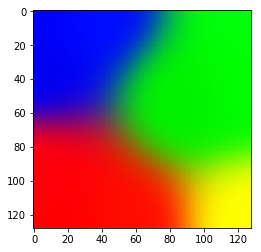

In [3]:
import matplotlib.pyplot as plt

# our inputs have 3 dimensions
colors = np.array(
     [[0., 0., 1.],
      [0., 0., 0.95],
      [0., 0.05, 1.],
      [0., 1., 0.],
      [0., 0.95, 0.],
      [0., 1, 0.05],
      [1., 0., 0.],
      [1., 0.05, 0.],
      [1., 0., 0.05],
      [1., 1., 0.]])

# we would like our map to be a 4x4 grid, also the dimensions of our inputs is 3 
# so we initialise as (4,4,3) -> (weight we would like for our grid, height we would like for our grid, 
# compulsory to be the same dimensions as input)
som = SOM(128, 128, 3)
# pass data to SOM
som.train(colors)

plt.imshow(som.centroid_grid)
plt.show()